# 1. Twitter Data

### The first step is to import the libraries required for twitter scraping and data manipulation 

In [16]:
import json
import time
import twitter
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',10)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from nltk.tokenize import word_tokenize
from string import punctuation 
from nltk.corpus import stopwords
import textblob

[nltk_data] Downloading package punkt to /Users/vasusingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vasusingh/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Setting up the authorization : Twitter APIs handle enormous amounts of data. The way this data is secured for developers and users alike is through authentication.

In [6]:
# To set up your Twitter app and get your secret key, refer to the README
# Enter your credentials below

consumer_key = ''
consumer_secret = ''
access_key= ''
access_secret = ''

# Authorization
twitter_api = twitter.Api(consumer_key = consumer_key,
                              consumer_secret = consumer_secret,
                              access_token_key = access_key,
                              access_token_secret= access_secret,
                              tweet_mode='extended') # extended mode for scraping the full text from tweets

### Scraping Tweets with a search keyword

In [9]:
def getmultipleData(search_keyword,no): # search_keyword -> topic to search tweets, no -> number of tweets
    
    count = 20 # count -> number of tweets to scrape in one request.Try to keep less to avoid duplicates.
    lowest_id = 0
    
    with open('Tweets'+ search_term + str('.json'),'a') as outfile: # opening json file to save the data
        
        time.sleep(5)
        results = twitter_api.GetSearch(term = search_keyword, count = count,lang = 'en')
        
        for tweet in results:
            tweet = str(tweet).replace('\n',' ').replace('\r',' ') # remove new lines
            tweet = (json.loads(tweet))
            lowest_id = tweet['id'] # keep track of lowest tweet on the current page
            json.dump(tweet,outfile)
            outfile.write('\n') #print tweets on new lines
            
        for i in range(0,(no-count)//count):
            
            time.sleep(5)
            results = twitter_api.GetSearch(term = search_keyword, count = count, max_id = lowest_id-1,lang = 'en')
            
            for tweet in results:
                tweet = str(tweet).replace('\n',' ').replace('\r',' ') # remove new lines
                tweet = (json.loads(tweet))
                lowest_id = tweet['id'] # keep track of lowest tweet on the current page
                json.dump(tweet,outfile)
                outfile.write('\n') #print tweets on new lines

                
# input for keyword and number of tweets                                
search_term = input('Enter Your Search Term : ')
no_of_tweets = int(input('How many Tweets Do you want ? : '))

print('Fetching Tweets : >>')
getmultipleData(search_term,no_of_tweets)
print('Done -->')


data = [json.loads(line) for line in open('Tweets'+ search_term + str('.json'), 'r')]

list_tweets = []

for i in range(len(data)):
    try: 
        list_tweets.append(data[i]['retweeted_status']['full_text'])    
    except:
        list_tweets.append(data[i]['full_text'])   
        
list_tweets = set(list_tweets) # Removing any duplicate/retweeted tweets

# final dataframe consisting of scraped tweets
final_df = pd.DataFrame(data = list_tweets,columns=['Tweet'])

Enter Your Search Term : coronavirus
How many Tweets Do you want ? : 600
Fetching Tweets : >>
Done -->


### Scraped Tweets:

In [14]:
final_df

,Tweet
0,I don’t know who needs to hear this but the gu...
1,Public Health England to be scrapped... \n\nTo...
2,Dear Nancy Pelosi: There is still a trillion d...
3,The EFF has rejected the easing of the lockdow...
4,Seriously people- STOP BUYING MASKS! \n\nThey...
...,...
407,"Over 167,000 die of coronavirus and Trump did ..."
408,@johnatkinsonsyd @SCMPNews Was that per year s...
409,RT: @piersmorgan The Govt’s 2020 coronavirus c...
410,Exclusive: Thousands of lives may be lost to c...


### Additional : It is also possible to scrape the tweets from users of choice. For this analysis we will stick to our previously scraped data

In [ ]:
## Getting Twitter Data from a Particular User

twitter_handles = ['PlattsOil','IEA','markets','IHSMarkit','EIAgov','WorldOil','OGJOnline','OPECSecretariat','OPIS',
                   'ftenergy','ETEnergyNews','ESAIEnergy','RefinitivEnergy','BloombergNRG']


twitter_people = ['realDonaldTrump','IEABirol','JZarif','SecPompeo','aeberman12']
    
def getuserdata(user_name):
    
    results = twitter_api.GetUserTimeline(screen_name = user_name,count = 600,include_rts = False,exclude_replies=True)
    l =  [{'Text':status.full_text,'Fav-Count':status.favorite_count,'Retweet-Count':status.retweet_count} for status in results]
    user_tweets = []
    for i in range(len(results)):
        
        user_tweets.append(l[i]['Text'])
    
    return user_tweets

choice = int(input('Enter Your Choice (1(Twitter Accounts) or 2(Important People Accounts)) : '))
print('Fetching Twitter Data -->')

if choice == 1:
    
    for i in twitter_handles:
    
        
        user_tweets = getuserdata(i)
        spec_df = pd.DataFrame(data = user_tweets,columns=['Tweet'])
        # Saving The Tweets
        writer = pd.ExcelWriter('Tweets_ '+ i +str('.xlsx'))
        # write dataframe to excel
        spec_df.to_excel(writer)
        # save the excel
        writer.save()
    
elif choice == 2:
    
    for i in twitter_people:
    
        
        user_tweets = getuserdata(i)
        spec_df = pd.DataFrame(data = user_tweets,columns=['Tweet'])
        # Saving The Tweets
        writer = pd.ExcelWriter('Tweets_ '+ i +str('.xlsx'))
        # write dataframe to excel
        spec_df.to_excel(writer)
        # save the excel
        writer.save()
    

### Next important step is to clean the tweets to better analyse/visualise the data

In [17]:
class PreProcessTweets:
    def __init__(self):
        self._stopwords = set(stopwords.words('english') + list(punctuation) + ['AT_USER','URL','rt','amp']) # to remove the stopwords

    def processTweets(self, list_of_tweets):
        processedTweets=[]
        for tweet in list_of_tweets:
            processedTweets.append((self._processTweet(tweet)))
            
        l = []
        for items in processedTweets:
            l.append(' '.join(items))
            
        df = pd.DataFrame(l,columns=['ProcessedTweets'])
        return df
    
    def _processTweet(self, tweet):
        tweet = tweet.lower() # convert text to lower-case
        tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet) # remove URLs
        tweet = re.sub('@[^\s]+', 'AT_USER', tweet) # remove usernames
        tweet = re.sub(r'#([^\s]+)', '', tweet) # remove the # in #hashtag
        tweet = word_tokenize(tweet) # remove repeated characters (helloooooooo into hello)
        return [word for word in tweet if word not in self._stopwords]

## Pre-Processing Our Tweets
tweetProcessor = PreProcessTweets()
cleaned_tweets = tweetProcessor.processTweets(final_df.Tweet)

# 2. Building WordCloud

Building The WordCloud : >>


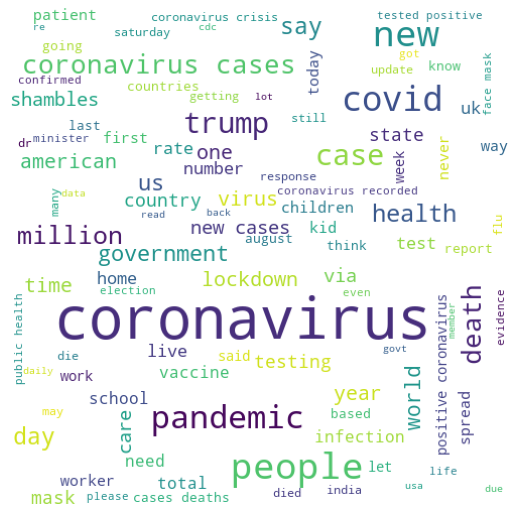

In [27]:
## Remember To clean The Tweets before for better results
def buildwordcloud(df):
    import wordcloud
    comment_words = ' '
    stopwords = set(wordcloud.STOPWORDS)# using stopwords included in wordcloud library
    stopwords = list(stopwords) + ['AT_USER','URL','rt','amp',"n't"] # adding our own stopwords
    for val in df['ProcessedTweets']:
        val = str(val)
        tokens = val.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        for word in tokens:
            comment_words = comment_words + word + ' '
    wordcloud = wordcloud.WordCloud(width=500,height=500,max_words = 100,background_color='white',stopwords=stopwords,min_font_size=10).generate(comment_words)

    # plot the wordcloud image
    plt.figure(figsize=(7,7),facecolor=None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

print('Building The WordCloud : >>')
buildwordcloud(cleaned_tweets)

# 3.Topic Modelling

### Automatically extract what topics people are discussing from large volumes of text

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles to give a DTM
count_data = count_vectorizer.fit_transform(cleaned_tweets['ProcessedTweets'])

import warnings
warnings.simplefilter('ignore',DeprecationWarning)

from sklearn.decomposition import LatentDirichletAllocation as LDA

def print_topics(model,count_vectorizer,n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx,topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Tweak the two parameters below

number_topics = 7
number_words = 5

# Create and fit the LDA model

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model

print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
coronavirus shambles 19 covid virus

Topic #1:
coronavirus people cases death deaths

Topic #2:
coronavirus trump died rid pandemic

Topic #3:
coronavirus new government health people

Topic #4:
coronavirus cases health new covid

Topic #5:
000 coronavirus cases people pandemic

Topic #6:
coronavirus new cases people pandemic


###### Note : The above results can be improved by using n-grams

# 4. Sentiment Score

### Sentiment analysis helps us identify emotions through social media texts

In [37]:
def senti(x):
    return textblob.TextBlob(x).sentiment.polarity

d1 = pd.DataFrame()
d1['Tweet'] = final_df['Tweet']
d1['Sentiment-Polarity'] = final_df['Tweet'].apply(senti)

avg_score = np.average(d1['Sentiment-Polarity'])
print('Average Polarity Score : ' +str(round(avg_score,3)))

Average Polarity Score : 0.046


In [88]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    l = []
    score = analyser.polarity_scores(sentence)
    l.append(score)
    return l
    
d1['vaderScore'] = final_df['Tweet'].apply(lambda x: sentiment_analyzer_scores(x))

d1['vaderScore'] = d1['vaderScore'][0][0]['compound']

avg_score = np.average(d1['vaderScore'])
print('Average vader Score : ' +str(round(avg_score,3)))

Average vader Score : -0.79
